# College Football Recruiting: An Analysis of Geographical Recruiting Trends and its Correlations with Winning
#### *By Rithvik Bobbili*

## Introduction

Recruiting is the heart of college football programs across the nation. Hundreds of thousands of dollars - even millions for the top schools - are spent scouting and attracting the top high school players in the country. Unlike in the NFL where the annual NFL draft and salary cap maintain a minimum parity in the league (hence the phrase "on any given Sunday, any team can beat any other team"), the NCAA is a free for all where the top football programs disproportionally attract the top recruits and thus continue their overwhelming success against other teams. However, every team will always have a budget - no school has unlimited resources and thus have to optimize their recruiting in one way or another.

In this tutorial, the goal is to explore how colleges recruit players geographically. Do the top programs tend to cast a wider net and recruit across the whole country, or do they simply do a better job of ensuring nearby stars go to their school? Are there any correlations between where colleges recruit from and how often teams win? Through this tutorial, we will explore how to download a dataset containing this geographical information, calculate various metrics, and analyze the data we have to try to conclude whether geographical trends in recruiting are correlated with winning. Through this analysis, we will hope to identify trends and potentially make conclusions on how Maryland can improve its own football team.

## Getting Started

In this tutorial, we will be using Python 3 along with several commonly used libraries. Libraries we will be using include numpy, pandas, matplotlib, haversine, seaborn, folium, and sklearn. 

One unique library we will be used is cfbd. This is simply a Python wrapper library for an API that queries CollegeFootballData.com. Documentation for this library can be found here: https://pypi.org/project/cfbd/

These libraries may require installation if they are not already installed in your environment, particularly cfbd. If you are unfamiliar with how to do this or what the best way is, I recommend using a virtual environment by following the instructions here https://packaging.python.org/en/latest/guides/installing-using-pip-and-virtual-environments/. Another option is just installing packages through your Jupyter notebook. An example of how to do this is in the cell below (some packages/dependencies may be missing and you will need to uncomment the code to actually run it):

In [1]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install folium
# !pip install sklearn
# !pip install cfbd
# !pip install haversine

After everything is installed, all that's left to do is import everything we will need later on.

In [2]:
import cfbd
import numpy as np
import cfbd
from cfbd.rest import ApiException
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import haversine as hs
from haversine import Unit
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium.features import DivIcon
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

Now we're ready to get to work!

## CFBD API Setup

The main dataset we will be using is the dataset on CollegeFootballData.com. However, the website has no way to directly download their databases easily at once - instead we will have to use their API via the CFBD wrapper class we imported earlier. In order to use this however, you will need to get an API key for yourself. Luckily, this API is free! All you need to do to get an API key is visit https://collegefootballdata.com/key and provide your email. They will the send you a key which you will need to set to ```configuration.api_key['Authorization']```

Within cfbd, there are multiple classes and endpoints that we can use to retrieve the data that we want. Documentation on how to use these specific classes/endpoints including helpful examples for each one can found at https://github.com/CFBD/cfbd-python#documentation-for-api-endpoints.

Before we use the API however, we need to setup to configuration to use the API key we retrieved.

In [3]:
# Configure API key authorization: ApiKeyAuth
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'Dm5Uz7MPJtZX5WaIzeAY6nEY8FduWcPjZXXwSDfWx81NRnMR15Q8hQJZnqahru3Q'
configuration.api_key_prefix['Authorization'] = 'Bearer'

The first dataset we will attempt to download will be recruiting data, so thus we will be using the RecruitingApi class. This data includes information on prospects coming out of school including rankings, name, high school, weight, height, where they committed to, stars, and hometown information. The API allows you to download data with various filters, but the only filter we will use is year. I decided to use the data for the last 5 years to have a good amount of data yet computationally managable. Since we want the data for the last 5 years, we can make 5 separate calls to the API and combine the data from each call into one big dataframe. To help us do this however, we will write a helper function that converts the response from one call into a Pandas dataframe. This way, we can just use this function to convert the API response for each year into dataframes and then combine them! Inside the function all we are doing is using a built in function of the cfbd library to turn the API response into a dictionary and then using Pandas to read that data into a dataframe.

*Note: This block of code may take a while to run. Added print statements to indicate after completion of processing each year's data.*

## Data Download/Pre-Processing

In [4]:
def convert_recruit_data_to_df(data):
    recruits_dict = []
    for athlete in data:
        recruits_dict.append(athlete.to_dict())
    return pd.DataFrame(recruits_dict)

In [5]:
recruiting_data = []
recruit_df = None
years = [2021, 2020, 2019, 2018, 2017]

# create an instance of the API class
api_instance = cfbd.RecruitingApi(cfbd.ApiClient(configuration))
try:    
    for curr_year in years:
        print("retrieving " + str(curr_year))
        if recruit_df is None:
            recruit_df = convert_recruit_data_to_df(api_instance.get_recruiting_players(year=curr_year))
        else:
            recruit_df = pd.concat([recruit_df, convert_recruit_data_to_df(api_instance.get_recruiting_players(year=curr_year))])
except ApiException as e:
    print("Exception when calling RecruitingApi->get_recruiting_players: %s\n" % e)
recruit_df.head()

retrieving 2021
retrieving 2020
retrieving 2019
retrieving 2018
retrieving 2017


,id,athlete_id,recruit_type,year,ranking,name,school,committed_to,position,height,weight,stars,rating,city,state_province,country,hometown_info
0,71458,4431274.0,HighSchool,2021,1.0,Korey Foreman,Centennial,USC,SDE,76.0,265.0,5,0.9994,Corona,CA,USA,"{'latitude': '33.8752945', 'longitude': '-117...."
1,71459,4431437.0,HighSchool,2021,2.0,JC Latham,IMG Academy,Alabama,OT,78.0,305.0,5,0.9990,Bradenton,FL,USA,"{'latitude': '27.4989278', 'longitude': '-82.5..."
2,71460,NaN,HighSchool,2021,3.0,J.T. Tuimoloau,Eastside Catholic,None,SDE,76.0,277.0,5,0.9990,Sammamish,WA,USA,"{'latitude': '47.6088445', 'longitude': '-122...."
3,71461,4431590.0,HighSchool,2021,4.0,Jack Sawyer,Pickerington North,Ohio State,SDE,77.0,248.0,5,0.9980,Pickerington,OH,USA,"{'latitude': '39.896277299999994', 'longitude'..."
4,71462,4432667.0,HighSchool,2021,5.0,Tommy Brockermeyer,All Saints Episcopal,Alabama,OT,78.0,283.0,5,0.9978,Fort Worth,TX,USA,"{'latitude': '32.753177', 'longitude': '-97.33..."


One problem we have to deal with is the sheer number of college teams. There are 131 schools in the NCAA Division 1 FBS - this could make analysis more difficult. Thus, I decided to use Big 10 schools (the conference Maryland plays in) along with ranking data from the past 5 years to select some of the top teams. In order to study a managable amount of teams, we will study all of the teams in the Big 10 plus any teams that have been ranked at least twice by the Playoffs Committee in the past 5 years. This way, we will be able to compare Maryland's football program to its direct competitors and some of the top teams in the country of the past 5 years. While we are sacrificing valuable data from other schools, the filtered dataset will be much easier to manipulate and perform analysis on

Similar to the API call we did for the recruiting data except now we use the RankingsApi class.

In [6]:
api_instance = cfbd.RankingsApi(cfbd.ApiClient(configuration))
season_type = 'postseason' # str | Season type filter (regular or postseason) (optional) (default to regular)

rankings_data = []

for year in years:
    try:
        # Historical polls and rankings
        rankings_data.append(api_instance.get_rankings(year=year, season_type=season_type))
    except ApiException as e:
        print("Exception when calling RankingsApi->get_rankings: %s\n" % e)

The following code simply compiles the list of teams that have been ranked at least twice in the past 5 years.

In [7]:
first_appearance = []
ranked_teams = []
for year_ranks in rankings_data:
    for team in year_ranks[0].to_dict()['polls'][0]['ranks']:
        if team['school'] not in first_appearance:
            first_appearance.append(team['school'])
        elif team['school'] in first_appearance and team['school'] not in ranked_teams:
            ranked_teams.append(team['school'])
ranked_teams

['Alabama',
 'Clemson',
 'Ohio State',
 'Notre Dame',
 'Oklahoma',
 'Cincinnati',
 'Georgia',
 'Iowa',
 'BYU',
 'Louisiana',
 'Oklahoma State',
 'NC State',
 'Oregon',
 'USC',
 'Miami',
 'Michigan State',
 'Northwestern']

In [8]:
len(ranked_teams)

17

In [9]:
big10_teams = ['Illinois', 'Indiana', 'Iowa', 'Maryland', 
              'Michigan', 'Michigan State', 'Minnesota',
              'Nebraska', 'Northwestern', 'Ohio State',
              'Penn State', 'Purdue', 'Rutgers', 'Wisconsin']
teams_of_interest = ranked_teams
for team in big10_teams:
    if team not in ranked_teams:
        teams_of_interest.append(team)
print(len(teams_of_interest))
teams_of_interest

27


['Alabama',
 'Clemson',
 'Ohio State',
 'Notre Dame',
 'Oklahoma',
 'Cincinnati',
 'Georgia',
 'Iowa',
 'BYU',
 'Louisiana',
 'Oklahoma State',
 'NC State',
 'Oregon',
 'USC',
 'Miami',
 'Michigan State',
 'Northwestern',
 'Illinois',
 'Indiana',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Nebraska',
 'Penn State',
 'Purdue',
 'Rutgers',
 'Wisconsin']

With the Big 10 teams and the other teams of interest, we have 27 teams in total. We will be analyzing how these 27 schools recruit and compare them against each other. The list of schools is:
- Alabama
- Clemson
- Ohio State
- Notre Dame
- Oklahoma
- Cincinnati
- Georgia
- Iowa
- BYU
- Louisiana
- Oklahoma State
- NC State
- Oregon
- USC
- Miami
- Michigan State
- Northwestern
- Illinois
- Indiana
- Maryland
- Michigan
- Minnesota
- Nebraska
- Penn State
- Purdue
- Rutgers
- Wisconsin

We will also want to retreive the team records for each team using the GamesApi class so that we can calculate winning percentages for each team later on. We will retrieve records for the same years as the data from before.

In [10]:
api_instance = cfbd.GamesApi(cfbd.ApiClient(configuration))

teams_records_df = None
list_of_record_dicts = []
for year in years:
    for team in teams_of_interest:
        try:
            response = api_instance.get_team_records(year=year, team=team)[0].to_dict()
            temp = response['total']
            temp['team'] = team
            temp['year'] = year
            temp['conference'] = response['conference']
            list_of_record_dicts.append(temp)    
        except ApiException as e:
            print("Exception when calling GamesApi->get_team_records: %s\n" % e)
team_records_df = pd.DataFrame(list_of_record_dicts)
team_records_df

,games,wins,losses,ties,team,year,conference
0,15,13,2,0,Alabama,2021,SEC
1,13,10,3,0,Clemson,2021,ACC
2,13,11,2,0,Ohio State,2021,Big Ten
3,13,11,2,0,Notre Dame,2021,FBS Independents
4,13,11,2,0,Oklahoma,2021,Big 12
...,...,...,...,...,...,...,...
130,12,4,8,0,Nebraska,2017,Big Ten
131,13,11,2,0,Penn State,2017,Big Ten
132,13,7,6,0,Purdue,2017,Big Ten
133,12,4,8,0,Rutgers,2017,Big Ten


Pandas makes calculating win percentage super easy! Win percentage will simply be games won divided by the number of total games played. We also want to add a column contain true/false values representing whether that school is in the Big10 to make plotting easier later on.

In [11]:
team_records_df['win_percentage'] = team_records_df['wins'] / team_records_df['games']
team_records_df['in_big10'] = team_records_df['conference'] == 'Big Ten'

team_records_df

,games,wins,losses,ties,team,year,conference,win_percentage,in_big10
0,15,13,2,0,Alabama,2021,SEC,0.866667,False
1,13,10,3,0,Clemson,2021,ACC,0.769231,False
2,13,11,2,0,Ohio State,2021,Big Ten,0.846154,True
3,13,11,2,0,Notre Dame,2021,FBS Independents,0.846154,False
4,13,11,2,0,Oklahoma,2021,Big 12,0.846154,False
...,...,...,...,...,...,...,...,...,...
130,12,4,8,0,Nebraska,2017,Big Ten,0.333333,True
131,13,11,2,0,Penn State,2017,Big Ten,0.846154,True
132,13,7,6,0,Purdue,2017,Big Ten,0.538462,True
133,12,4,8,0,Rutgers,2017,Big Ten,0.333333,True


The last bit of data we will need is location information for the colleges themselves. While there is a team information API endpoint that seems to contain this information, through my own personal testing at the time of writing the endpoint was not working correctly. Most of the locations when that method was used were missing. Thus, especially due to the number of school we are studying being relatively managable, I compiled data on the coordinates of these colleges. While a web-scraping method was considered, due to the managable college count a manual approach was taken to ensure accuracy of these coordinates. The csv file containing location information for the college teams of interest can be found at either:
https://github.com/rithvikb/320FinalProject/blob/main/FinalProject/location_data.csv
https://drive.google.com/file/d/1KtLo28xr_vfSCy53pCuY5gR8JjT7E8JP/view?usp=sharing

In [12]:
location_df = pd.read_csv('location_data.csv') # Use pandas to read csv into dataframe
location_df.head()

,school,conference,location.latitude,location.longitude,State
0,Illinois,Big Ten,40.099300,-88.236000,IL
1,Indiana,Big Ten,39.180896,-86.525622,IN
2,Iowa,Big Ten,41.658605,-91.551083,IA
3,Maryland,Big Ten,38.990333,-76.947379,MD
4,Michigan,Big Ten,42.265836,-83.748696,MI


In [13]:
toi_recruits_df = recruit_df[recruit_df['committed_to'].isin(teams_of_interest)] # filtering recruits going to our teams of interest
toi_recruits_df.head()

,id,athlete_id,recruit_type,year,ranking,name,school,committed_to,position,height,weight,stars,rating,city,state_province,country,hometown_info
0,71458,4431274.0,HighSchool,2021,1.0,Korey Foreman,Centennial,USC,SDE,76.0,265.0,5,0.9994,Corona,CA,USA,"{'latitude': '33.8752945', 'longitude': '-117...."
1,71459,4431437.0,HighSchool,2021,2.0,JC Latham,IMG Academy,Alabama,OT,78.0,305.0,5,0.9990,Bradenton,FL,USA,"{'latitude': '27.4989278', 'longitude': '-82.5..."
3,71461,4431590.0,HighSchool,2021,4.0,Jack Sawyer,Pickerington North,Ohio State,SDE,77.0,248.0,5,0.9980,Pickerington,OH,USA,"{'latitude': '39.896277299999994', 'longitude'..."
4,71462,4432667.0,HighSchool,2021,5.0,Tommy Brockermeyer,All Saints Episcopal,Alabama,OT,78.0,283.0,5,0.9978,Fort Worth,TX,USA,"{'latitude': '32.753177', 'longitude': '-97.33..."
5,71463,4431611.0,HighSchool,2021,6.0,Caleb Williams,Gonzaga,Oklahoma,DUAL,73.0,210.0,5,0.9971,Washington,DC,USA,"{'latitude': '38.8949855', 'longitude': '-77.0..."


## Calculating distances

Now that we have all of our dataframes ready to go, we want to calculate how far each recruit's hometown is from the college they committed to. To do this, we will use the haversine library to calculate the Haversine distance between 2 coordinates. The Haversine distance is based on the formula $D(x, y) = 2\arcsin[\sqrt{\sin^2((x1 - y1) / 2)
                         + \cos(x1)\cos(y1)\sin^2((x2 - y2) / 2)}]$, which is the angular distance between two points on the surface of a sphere. The first coordinate of each point is assumed to be the latitude, the second is the longitude. We'll create a new column containing each recruit's distance from hometown to the college they committed to.

In [14]:
def calc_player_dist(player):
    school = player['committed_to']
    loc1lat = player['hometown_info']['latitude']
    loc1long = player['hometown_info']['longitude']
    loc2lat = location_df[location_df['school'] == school]['location.latitude']
    loc2long = location_df[location_df['school'] == school]['location.longitude']
    if loc1lat == None or loc1long == None:
        return pd.NA
    loc1 = (float(player['hometown_info']['latitude']), float(player['hometown_info']['longitude']))
    loc2 = (float(location_df[location_df['school'] == school]['location.latitude']), 
            float(location_df[location_df['school'] == school]['location.longitude']))
    return hs.haversine(loc1, loc2, unit=Unit.MILES)

In [15]:
toi_recruits_df['school_dist'] = toi_recruits_df.apply(calc_player_dist, axis=1)

It will also be helpful to put the win percentage of the school they committed to in the same dataframe for easy plotting later on. To do this easily, we wrote a quick function getting the win percentages from the team records dataframe.

In [16]:
def get_team_win_perc(player):
    school = player['committed_to']
    return pd.DataFrame.mean(team_records_df[team_records_df['team'] == school]['win_percentage'])

In [17]:
toi_recruits_df['win_perc'] = toi_recruits_df.apply(get_team_win_perc, axis=1)
toi_recruits_df.head()

,id,athlete_id,recruit_type,year,ranking,name,school,committed_to,position,height,weight,stars,rating,city,state_province,country,hometown_info,school_dist,win_perc
0,71458,4431274.0,HighSchool,2021,1.0,Korey Foreman,Centennial,USC,SDE,76.0,265.0,5,0.9994,Corona,CA,USA,"{'latitude': '33.8752945', 'longitude': '-117....",42.42548,0.596886
1,71459,4431437.0,HighSchool,2021,2.0,JC Latham,IMG Academy,Alabama,OT,78.0,305.0,5,0.9990,Bradenton,FL,USA,"{'latitude': '27.4989278', 'longitude': '-82.5...",493.319439,0.914945
3,71461,4431590.0,HighSchool,2021,4.0,Jack Sawyer,Pickerington North,Ohio State,SDE,77.0,248.0,5,0.9980,Pickerington,OH,USA,"{'latitude': '39.896277299999994', 'longitude'...",14.950824,0.887088
4,71462,4432667.0,HighSchool,2021,5.0,Tommy Brockermeyer,All Saints Episcopal,Alabama,OT,78.0,283.0,5,0.9978,Fort Worth,TX,USA,"{'latitude': '32.753177', 'longitude': '-97.33...",568.298173,0.914945
5,71463,4431611.0,HighSchool,2021,6.0,Caleb Williams,Gonzaga,Oklahoma,DUAL,73.0,210.0,5,0.9971,Washington,DC,USA,"{'latitude': '38.8949855', 'longitude': '-77.0...",1151.302918,0.847153


## Plotting Average Distance of Recruits by School

Before average distance of recruits by school can be plotted, the averages need to be calculate for both recruit distances and the win percentages (since in our dataframe we have win percentages for each year). We do this using the mean function built into Pandas and calculating the means for each team and putting them into lists. These lists are then used to create a dictionary that we can turn back into a dataframe containing the information we want for our plots!

In [18]:
toi_win_perc_list = []
toi_avg_recruit_dist = []
for team in teams_of_interest:
    toi_avg_recruit_dist.append(pd.DataFrame.mean(toi_recruits_df[toi_recruits_df['committed_to'] == team]['school_dist']))
    toi_win_perc_list.append(pd.DataFrame.mean(team_records_df[team_records_df['team'] == team]['win_percentage']))

In [19]:
dist_vs_wins_df = pd.DataFrame({'School': teams_of_interest, 'School Distance': toi_avg_recruit_dist, 'Win Percentage': toi_win_perc_list})
dist_vs_wins_df['big10'] = dist_vs_wins_df['School'].isin(big10_teams)
dist_vs_wins_df.head()

,School,School Distance,Win Percentage,big10
0,Alabama,466.629961,0.914945,False
1,Clemson,325.387483,0.878608,False
2,Ohio State,584.463301,0.887088,True
3,Notre Dame,824.742570,0.843590,False
4,Oklahoma,476.525675,0.847153,False


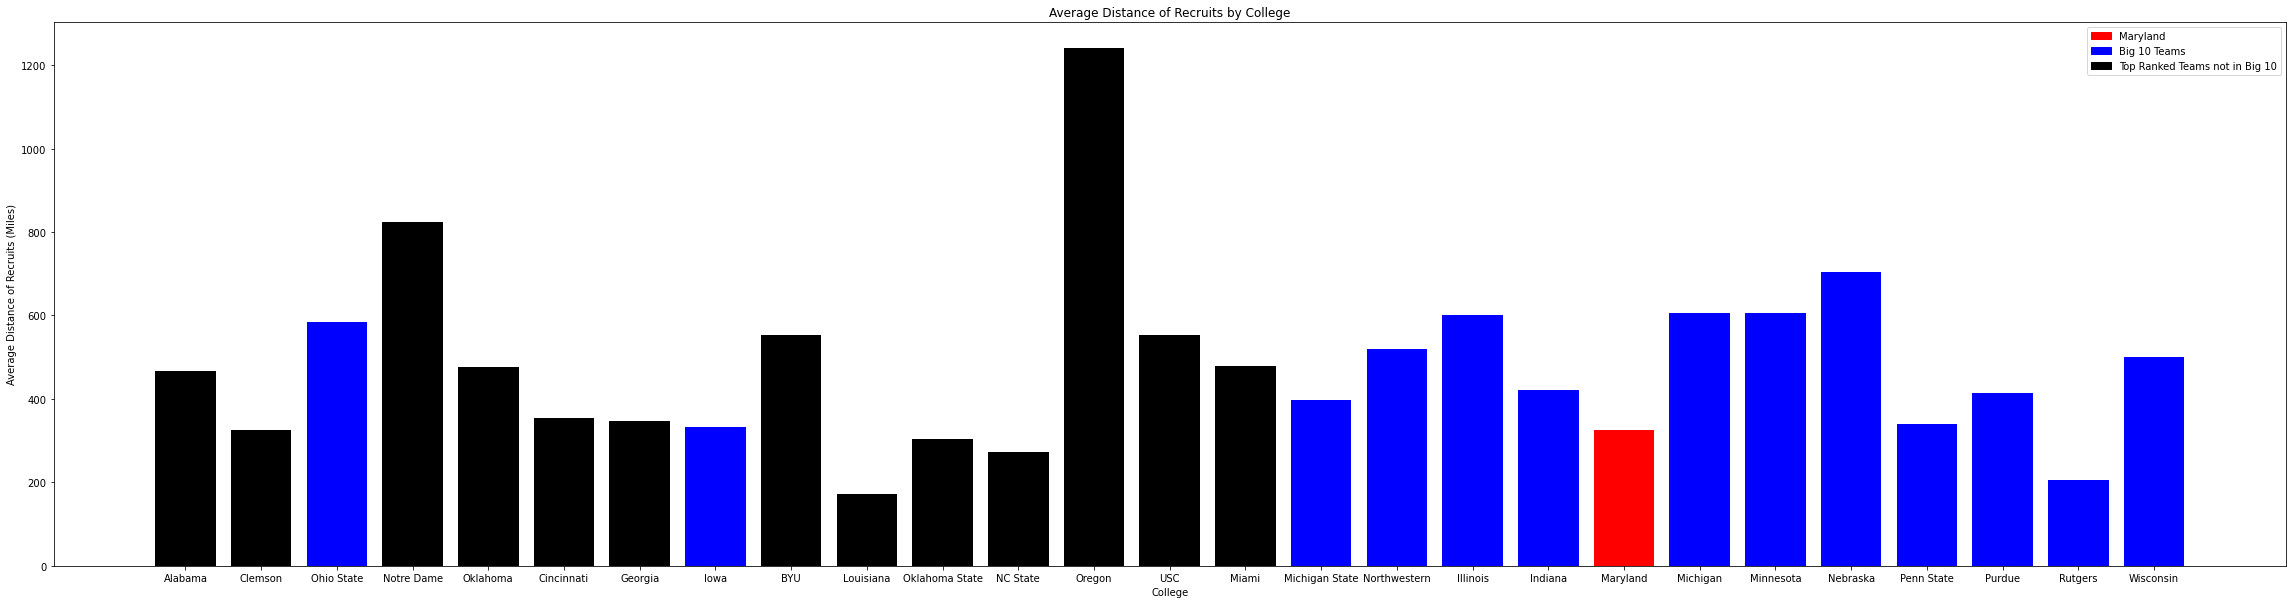

In [20]:
plt.figure(figsize=(40,10))
plt.xlabel('College')
plt.ylabel('Average Distance of Recruits (Miles)')
plt.title('Average Distance of Recruits by College')

colors = np.where(dist_vs_wins_df['big10']==True,'b','k')
colors[19] = 'r' # Maryland
blue_patch = mpatches.Patch(color='blue', label='Big 10 Teams')
black_patch = mpatches.Patch(color='black', label='Top Ranked Teams not in Big 10')
red_patch = mpatches.Patch(color='red', label='Maryland')

plt.bar(dist_vs_wins_df['School'], dist_vs_wins_df['School Distance'], color=colors)
plt.legend(handles=[red_patch, blue_patch, black_patch])

This is a bar graph showing the average distance of recruits in miles for each college football program. Oregon's average distance is a clear outlier, but this could be due to Oregon's location. Oregon is the only college on this list in the Northwest (despite there being a school named Northwestern on this list).

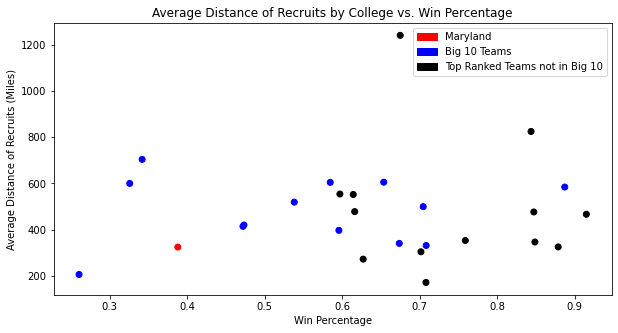

In [21]:
plt.figure(figsize=(10,5))
plt.xlabel('Win Percentage')
plt.ylabel('Average Distance of Recruits (Miles)')
plt.title('Average Distance of Recruits by College vs. Win Percentage')
g = plt.scatter(dist_vs_wins_df['Win Percentage'], dist_vs_wins_df['School Distance'], c=colors)

plt.legend(handles=[red_patch, blue_patch, black_patch])
plt.show(g)

This is a scatter plot comparing average distance of recruits against win percentage. Based on this chart, there are no clear trends and the points seem to be distributed relatively sparsely. Most of the data points lie in a similar range and there is not a clear correlation between these two variables.

I was also curious whether the average distance of recruits have any specific trends over time. To study this, I plotted the average distance of recruits for each school over time. In order to do this however, I had to first write another helper function to calculate the average distance of recruits for that season's recruits. I then used the Seaborn library to plot line plots.

In [22]:
def calc_avg_dist_for_year(season):
    season['team']
    season['year']
    filtered_recruits = toi_recruits_df[toi_recruits_df['committed_to'] == season['team']]
    filtered_recruits = filtered_recruits[filtered_recruits['year'] == season['year']]
    return pd.DataFrame.mean(filtered_recruits['school_dist'])
    

recruit_dist_over_time = team_records_df
recruit_dist_over_time['recruit_dist'] = recruit_dist_over_time.apply(calc_avg_dist_for_year, axis=1)
recruit_dist_over_time.head()

,games,wins,losses,ties,team,year,conference,win_percentage,in_big10,recruit_dist
0,15,13,2,0,Alabama,2021,SEC,0.866667,False,406.422107
1,13,10,3,0,Clemson,2021,ACC,0.769231,False,392.331685
2,13,11,2,0,Ohio State,2021,Big Ten,0.846154,True,488.059582
3,13,11,2,0,Notre Dame,2021,FBS Independents,0.846154,False,833.312720
4,13,11,2,0,Oklahoma,2021,Big 12,0.846154,False,631.056952


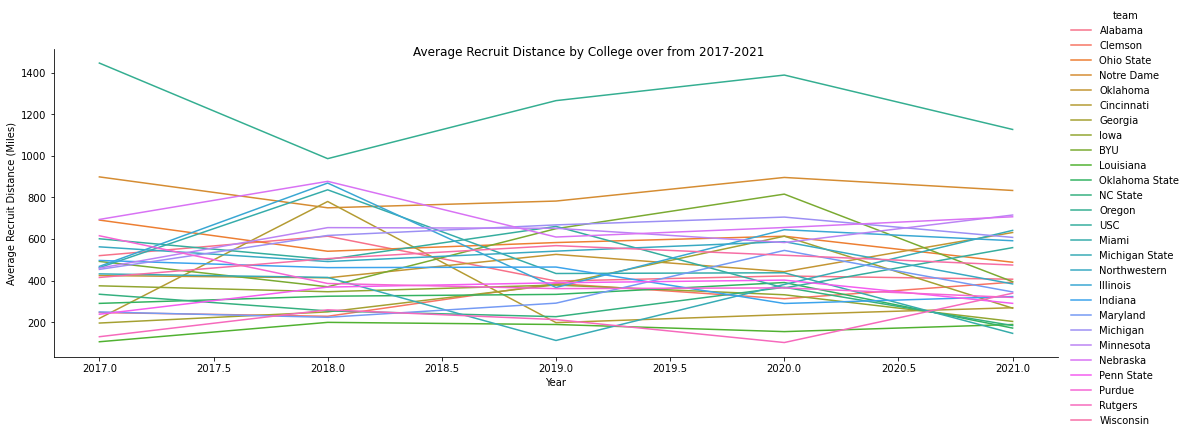

In [23]:
total = sns.relplot(data = recruit_dist_over_time, x="year", y="recruit_dist", hue="team", aspect = 3, kind="line")
total.figure.suptitle("Average Recruit Distance by College over from 2017-2021")
total.set_axis_labels("Year", "Average Recruit Distance (Miles)")
plt.show(total)

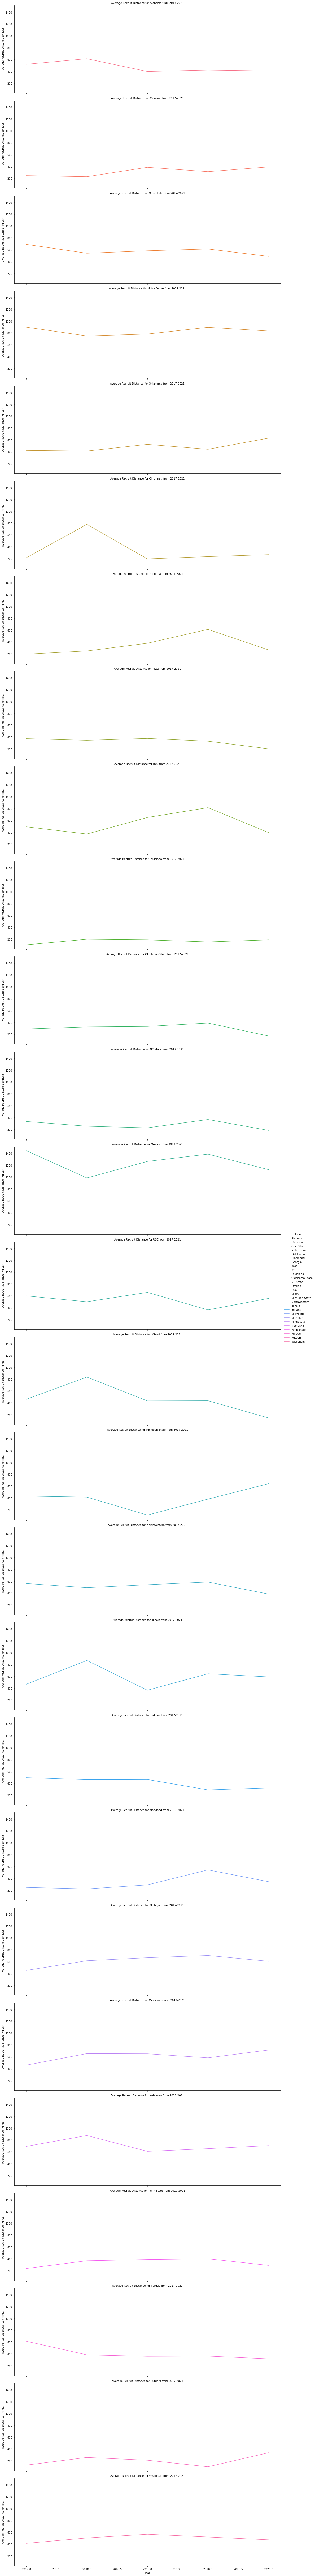

In [24]:
individual = sns.relplot(data = recruit_dist_over_time, x="year", y="recruit_dist", hue="team", row="team", aspect = 3, kind="line")
individual.set_titles("Average Recruit Distance for {row_name} from 2017-2021")
individual.set_axis_labels("Year", "Average Recruit Distance (Miles)")
plt.show(individual)

Based on these line plots, there is no clear trend in the average recruit distance over time. While they all fluctuate and some more than others, there is no clear pattern shared by these line plots that would indicate that recruiting programs are expanding or shrinking their recruiting bases. College recruiting can be heavily reliant on networking and connections college staff have with high school staff, so perhaps this is why average recruit distance is relatively stable. 

## Analyzing how effective college football programs are at recruiting in-state stars

One thing I was curious to see is how successful college programs are at recruiting in-state stars. Theoretically, recruiting programs should have an advantage with hometown players because many kids would love to stay close to home. Ensuring local talent goes to your program also seems like it would be a good way to ensure a stable recruiting base, as long as the area your program is located in has a lot of talent. I was curious to see how this statistic I will call "star retention" will correlate with win_percentage and whether there are any specific revealing trends regarding it. To calculate star retention, I took calculated # stars going to program divided by the total number of stars in state. I tested various definitions of a "star" as well, defining "stars" as 5 stars, 4+ stars, and 3+ stars. Each star retention statistic for each definition was calculated for each school and put in its own column.

In [25]:
instate_star_retention = location_df

stars_df = toi_recruits_df[toi_recruits_df['stars'] >= 5]

def calc_star_retention(school):
    in_state_stars = stars_df[stars_df['state_province'] == school['State']]
    
    total_stars = in_state_stars.shape[0] # counting rows
    recruited_stars = in_state_stars[in_state_stars['committed_to'] == school['school']].shape[0]
    if total_stars == 0:
        return 0
    return recruited_stars / total_stars

def get_win_data(school):
    temp = team_records_df[team_records_df['team'] == school['school']]
    return pd.DataFrame.mean(temp['win_percentage'])

In [26]:
instate_star_retention['win_percentage'] = instate_star_retention.apply(get_win_data, axis=1)

stars_df = toi_recruits_df[toi_recruits_df['stars'] >= 5]
instate_star_retention['5star_retention'] = instate_star_retention.apply(calc_star_retention, axis=1)

stars_df = toi_recruits_df[toi_recruits_df['stars'] >= 4]
instate_star_retention['4star_retention'] = instate_star_retention.apply(calc_star_retention, axis=1)

stars_df = toi_recruits_df[toi_recruits_df['stars'] >= 3]
instate_star_retention['3star_retention'] = instate_star_retention.apply(calc_star_retention, axis=1)

instate_star_retention.head()

,school,conference,location.latitude,location.longitude,State,win_percentage,5star_retention,4star_retention,3star_retention
0,Illinois,Big Ten,40.099300,-88.236000,IL,0.325641,0.000000,0.047619,0.180451
1,Indiana,Big Ten,39.180896,-86.525622,IN,0.473077,0.000000,0.222222,0.317073
2,Iowa,Big Ten,41.658605,-91.551083,IA,0.708242,0.000000,0.700000,0.720930
3,Maryland,Big Ten,38.990333,-76.947379,MD,0.387692,0.000000,0.263158,0.423529
4,Michigan,Big Ten,42.265836,-83.748696,MI,0.653480,0.333333,0.476190,0.218487


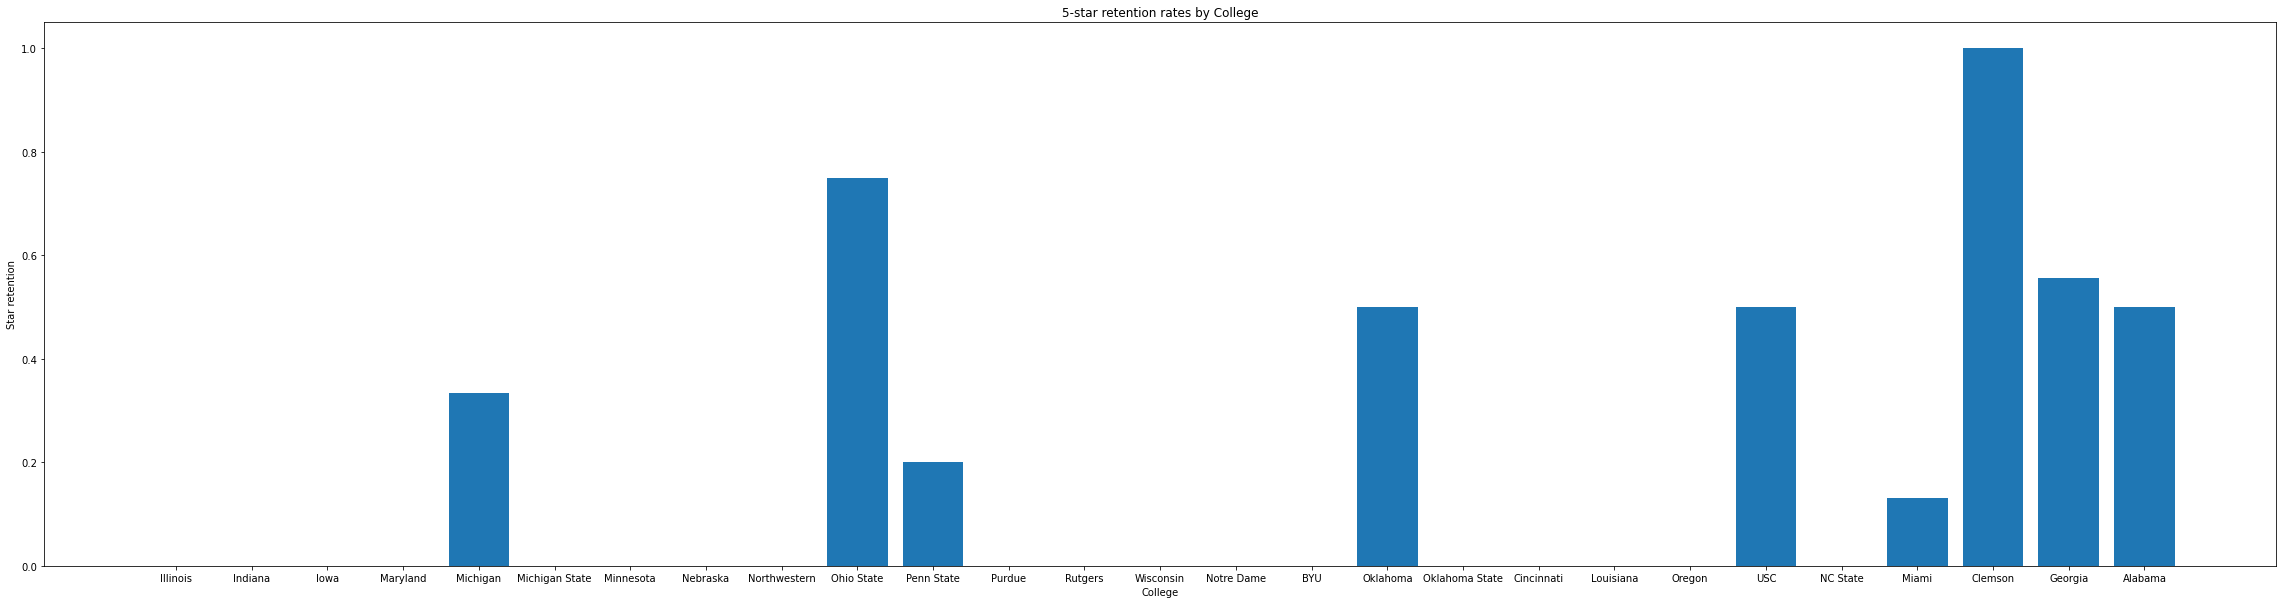

In [27]:
plt.figure(figsize=(40,10))
plt.xlabel('College')
plt.ylabel('Star retention')
plt.title('5-star retention rates by College')
g = plt.bar(instate_star_retention['school'], instate_star_retention['5star_retention'])

5 star rated players are the cream of the crop, so wherever these players go can be a signifcant indicator of success. It is no surprise that top teams like Georgia and Alabama have high star retention rates - but I was surprised to see Clemson have such a high 5 star-retention rate. Many of the schools either had no 5 stars in their state or failed to recruit any in-state 5 stars.

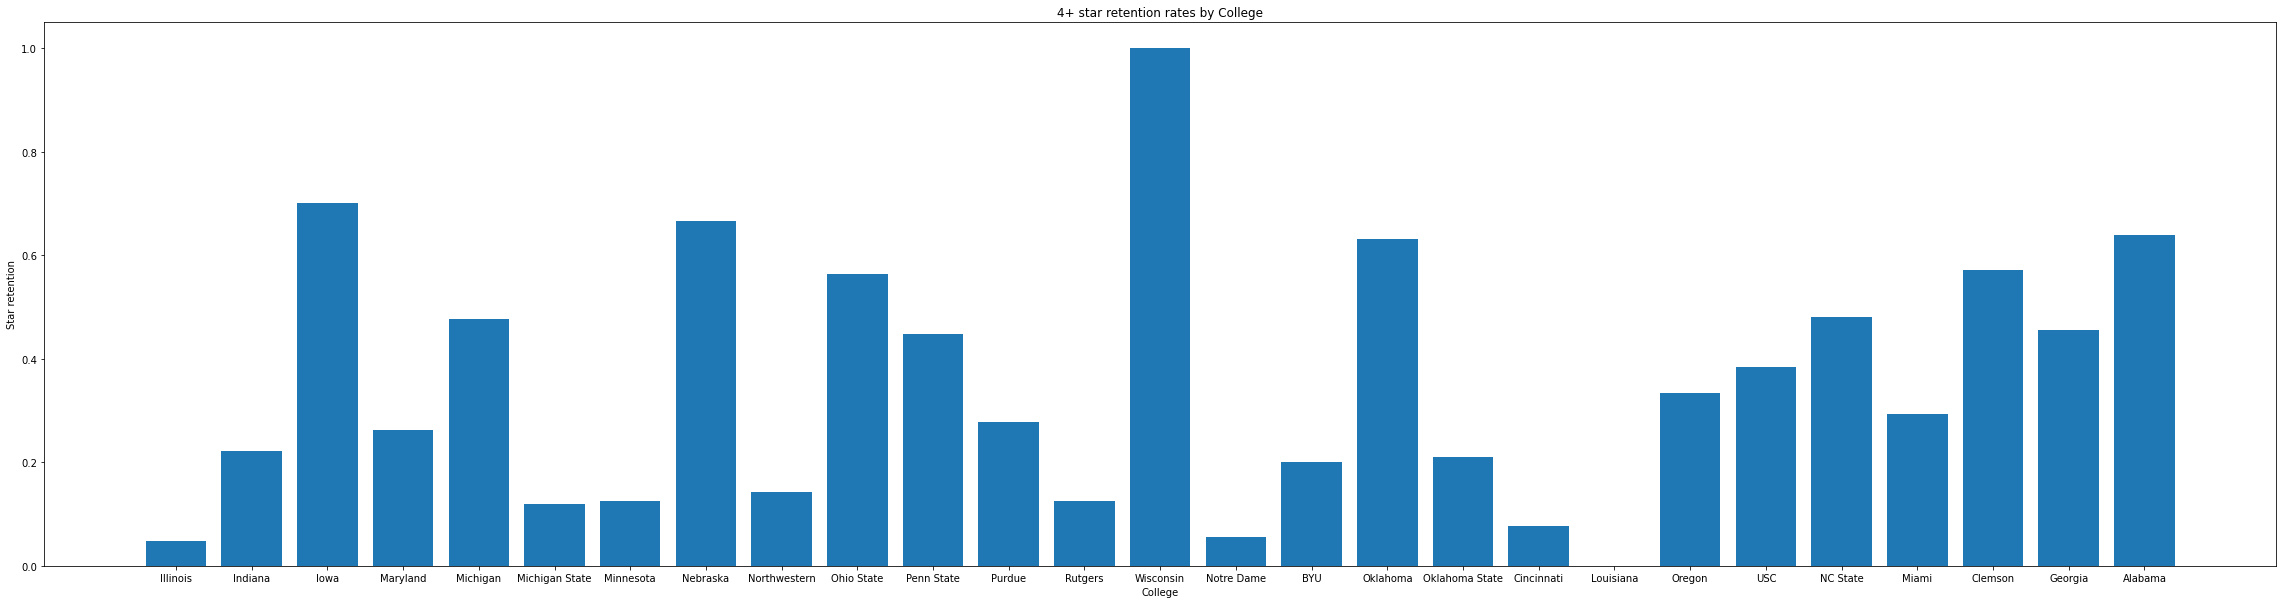

In [28]:
plt.figure(figsize=(40,10))
plt.xlabel('College')
plt.ylabel('Star retention')
plt.title('4+ star retention rates by College')
g = plt.bar(instate_star_retention['school'], instate_star_retention['4star_retention'])

It is interesting to see how different the bar graph for 4+ star retention rate is. It is suprising USC and Louisiana still have a 0 star-retention rate, especially considering they are located in California and Louisiana respectively - which are not areas devoid of football talent. There is also a clear outlier with Wisconsin having a very high 4+ star retention rate. Since Wisconsin was at 0 for 5 star retention rate but so high for 4+, this means that there is almost no if not no 5 star talent in Wisconsin at least during the timeframe this data is about.

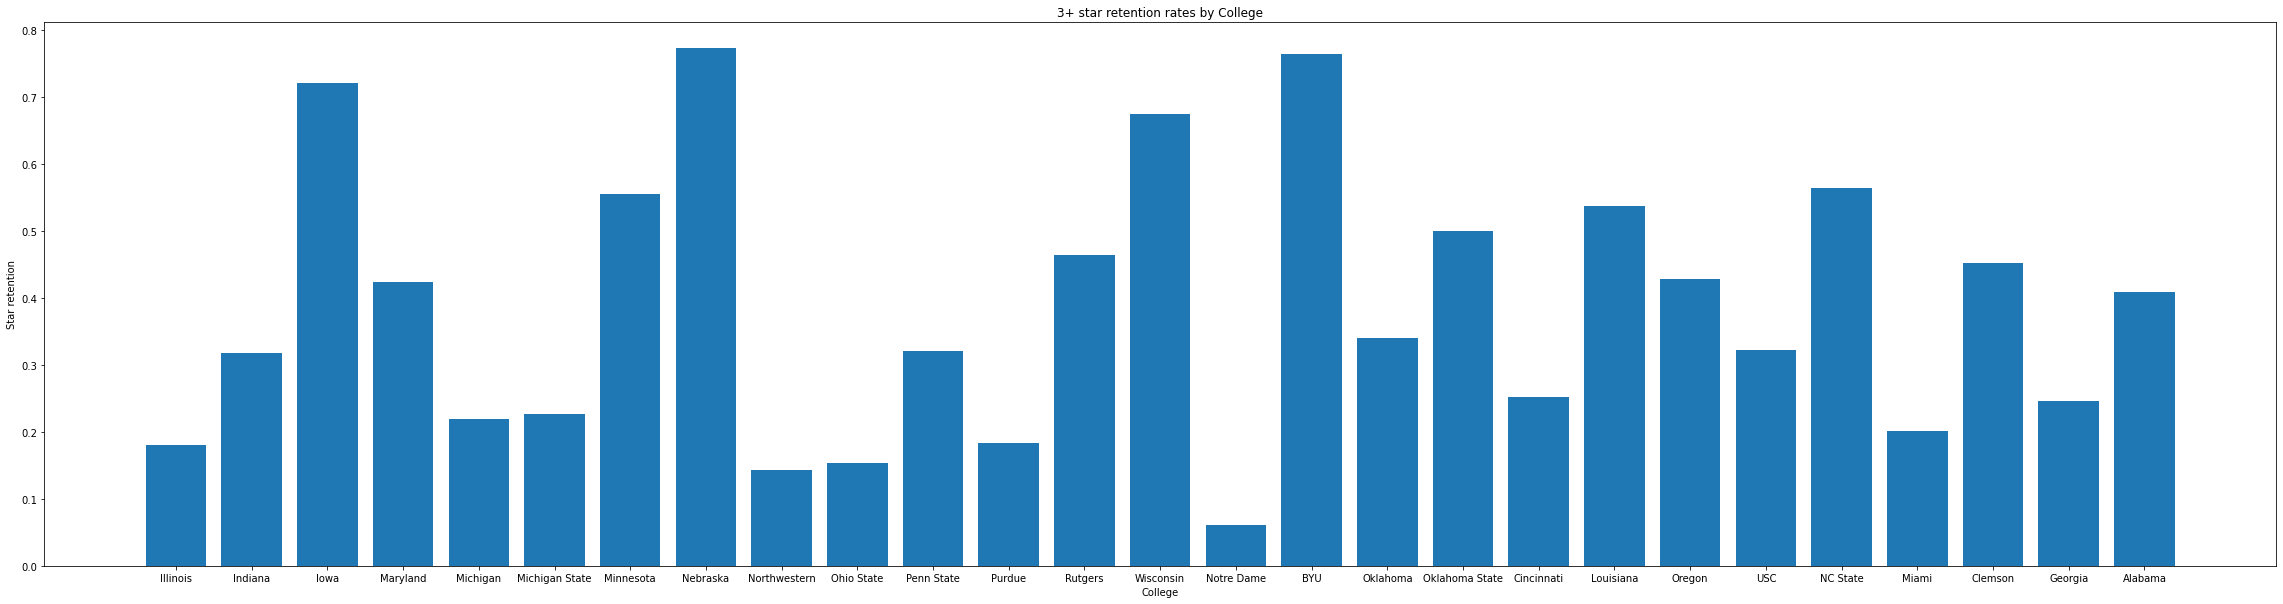

In [29]:
plt.figure(figsize=(40,10))
plt.xlabel('College')
plt.ylabel('Star retention')
plt.title('3+ star retention rates by College')
g = plt.bar(instate_star_retention['school'], instate_star_retention['3star_retention'])

One interesting trend from this graph of the 3+ star retention rate is that the 3 highest are Nebraska, Iowa, and BYU. These 3 programs are in relatively more isolated states and face little high-end competition for recruits within their state - so while they might not have many 5 star recruits from those states they are keeping within they do a good job of recruiting all 3+ star players in-state. Other schools, even if they have far better programs likely have lower star retention rates as they face much stiffer competition either against schools in the same state or neighboring states.

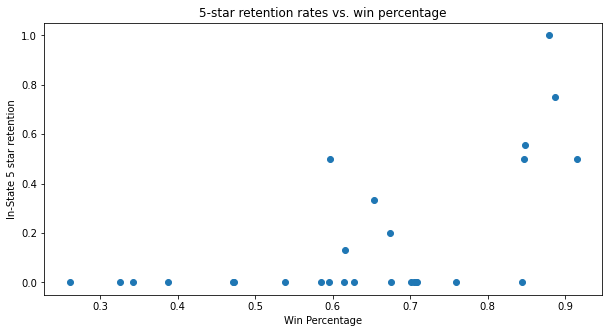

In [30]:
plt.figure(figsize=(10,5))
plt.xlabel('Win Percentage')
plt.ylabel('In-State 5 star retention')
plt.title('5-star retention rates vs. win percentage')
g = plt.scatter(instate_star_retention['win_percentage'], instate_star_retention['5star_retention'])

Based on visual inspection of this scatter plot, there is a clear correlation between 5 star retention rate and win percentage. While we can't prove causation just based off of this scatter plot, this suggests that more successful college football programs may do a better job of keeping elite in-state talent flowing into their programs. However, this plot may be skewed by the fact that many datapoints have 0 star-retention rates, which exaggerates the correlation trend. However, even if all points with 0 star retention rates were removed, there would still be a clear positive correlation.

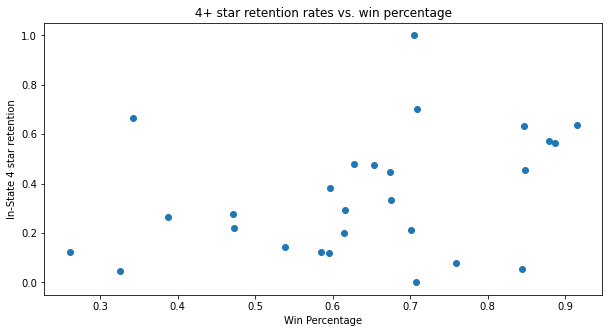

In [31]:
plt.figure(figsize=(10,5))
plt.xlabel('Win Percentage')
plt.ylabel('In-State 4 star retention')
plt.title('4+ star retention rates vs. win percentage')
g = plt.scatter(instate_star_retention['win_percentage'], instate_star_retention['4star_retention'])

Based on this scatter plot of star retention rates of 4+ star recruits, there is still a correlation between star retention rates and win percentage - however the correlation is weaker. 

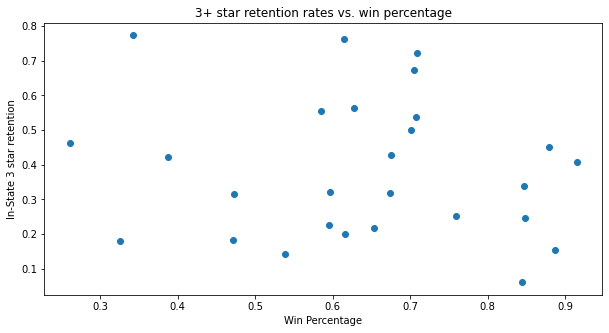

In [32]:
plt.figure(figsize=(10,5))
plt.xlabel('Win Percentage')
plt.ylabel('In-State 3 star retention')
plt.title('3+ star retention rates vs. win percentage')
g = plt.scatter(instate_star_retention['win_percentage'], instate_star_retention['3star_retention'])

Based on this scatter plot of star retention rates of 3+ star recruits, there does not seem to be a clear correlation in any way. The points are sparsely distributed and there are no clear trends within this graph. This could indicate that retaining elite in-state talent is important but it might not be as important to keep lower level talent.

## Heatmap of recruits and college football programs

In order to better understand the context of where these colleges are located, we can create an interactive map containing markers representing the college locations and a heatmap representing where recruits are located. This can illustrate which colleges are located near talent and which colleges might be forced to search further for talent.

To do this, we have to create 2 helper functions to have latitude and longitude each represent in columns as float values. Then, we can create a heat map of recruits showing where most 5-star recruits are located. Red indicated a higher density of 5-star recruits and blue represents a lower density. If no color is overlayed on the map, there are no 5-star recruits from that area. 

In [33]:
def getPlayerLatitude(player):
    if player['hometown_info'] != None and player['hometown_info']['latitude'] != None:
        return float(player['hometown_info']['latitude'])
    else:
        return None
    
def getPlayerLongitude(player):
    if player['hometown_info'] != None and player['hometown_info']['longitude'] != None:
        return float(player['hometown_info']['longitude'])
    else:
        return None

In [34]:
m = folium.Map(location=[40, -95], zoom_start=4)

heatmap_df = toi_recruits_df

heatmap_df['latitude'] = heatmap_df.apply(getPlayerLatitude, axis=1)
heatmap_df['longitude'] = heatmap_df.apply(getPlayerLongitude, axis=1)

heatmap_df = heatmap_df[heatmap_df['stars'] == 5]

heatmap_df = heatmap_df[['latitude', 'longitude']]
heatmap_df = heatmap_df.dropna(axis=0, subset=['latitude', 'longitude'])


heat_data = [[row['latitude'],row['longitude']] for index, row in heatmap_df.iterrows()]
HeatMap(heat_data).add_to(m)

for index, college in location_df.iterrows():
    folium.Marker(location=[college['location.latitude'], college['location.longitude']], icon=folium.Icon(color='red')).add_to(m)
    folium.Marker(location=[college['location.latitude'], college['location.longitude']], icon=DivIcon(icon_size=(250,36), icon_anchor=(0,0), html=('<div style="font-size: 10pt;">' + college['school'] + '</div>'))).add_to(m)
m

## Regressions
In order to more mathematically study the scatter plots we made throughout this project, we can conduct a series of linear regressions using sklearn.

In [35]:
school_distance = dist_vs_wins_df['School Distance'].values.reshape(-1, 1)
win_perc = dist_vs_wins_df['Win Percentage'].values.reshape(-1, 1)

linreg = LinearRegression()
linreg.fit(school_distance, win_perc)
coeff = linreg.coef_[0,0]
intercept = linreg.intercept_[0]
print("The slope is: ", coeff)
print("The y-intercept is: ", intercept)
print("The model can be given by: ", coeff, '* x + (',intercept, ')')

The slope is:  3.722794023857519e-05
The y-intercept is:  0.6205060684434415
The model can be given by:  3.722794023857519e-05 * x + ( 0.6205060684434415 )


Based on this slope, there is not a significant correlation between average recruit distance and win percentage. The slope is extremely small and while it is positive, does not suggest a strong correlation between these two variables.

In [36]:
five_star_retention = instate_star_retention['5star_retention'].values.reshape(-1, 1)
win_perc = instate_star_retention['win_percentage'].values.reshape(-1, 1)

linreg = LinearRegression()
linreg.fit(five_star_retention, win_perc)
coeff = linreg.coef_[0,0]
intercept = linreg.intercept_[0]
print("Linear Regression of 5-star recruit in-state retention")
print("The slope is: ", coeff)
print("The y-intercept is: ", intercept)
print("The model can be given by: ", coeff, '* x + (',intercept, ')')

Linear Regression of 5-star recruit in-state retention
The slope is:  0.3780839996606681
The y-intercept is:  0.5757333779660393
The model can be given by:  0.3780839996606681 * x + ( 0.5757333779660393 )


In [37]:
four_star_retention = instate_star_retention['4star_retention'].values.reshape(-1, 1)
win_perc = instate_star_retention['win_percentage'].values.reshape(-1, 1)

linreg = LinearRegression()
linreg.fit(four_star_retention, win_perc)
coeff = linreg.coef_[0,0]
intercept = linreg.intercept_[0]
print("Linear Regression of 4+ star recruit in-state retention")
print("The slope is: ", coeff)
print("The y-intercept is: ", intercept)
print("The model can be given by: ", coeff, '* x + (',intercept, ')')

Linear Regression of 4+ star recruit in-state retention
The slope is:  0.24825443594789678
The y-intercept is:  0.5508849720435531
The model can be given by:  0.24825443594789678 * x + ( 0.5508849720435531 )


Based on this slope, there is a significant postive correlation between 5-star retention and win-percentage. As mentioned before when looking at the scatterplot for this graph, this can indicate that the top footall programs do a good job of keeping elite in-state talent flowing into their programs. The regression for 4+ star retention shows a similar trend but has a weaker slope. This could mean college recruiting programs should focus on 5-star talent first as such high-impact players may contribute directly to more wins.

In [38]:
three_star_retention = instate_star_retention['3star_retention'].values.reshape(-1, 1)
win_perc = instate_star_retention['win_percentage'].values.reshape(-1, 1)

linreg = LinearRegression()
linreg.fit(three_star_retention, win_perc)
coeff = linreg.coef_[0,0]
intercept = linreg.intercept_[0]
print("Linear Regression of 3+ star recruit in-state retention")
print("The slope is: ", coeff)
print("The y-intercept is: ", intercept)
print("The model can be given by: ", coeff, '* x + (',intercept, ')')

Linear Regression of 3+ star recruit in-state retention
The slope is:  -0.12226805448900359
The y-intercept is:  0.68554446731509
The model can be given by:  -0.12226805448900359 * x + ( 0.68554446731509 )


The regression for 3+ star recruits does not match the other two regressions. This is not surprising, especially looking at the scatter plot for this data which seems pretty randomly distributed. This could be because there will be far more 3-star level talent than 5-star level talent, so it is not that important or even feasible for college football programs to recruit all of them to their program. 5-star level talent obviously attracts the most attention and will receive the most effort, so this could be the reason for the lack of correlation for this regression.

## Conclusions

Based on the various ways we explored the data, there is no obvious trend indicating that average distance of recruits is correlated with win percentage. This may mean that the average distance of recruits is simply a fucntion of where colleges are located and not really a function of how strong a recruiting program is. This is further supported by the fact that Oregon is a clear outlier when comparing the average distance of recruits, since Oregon is relatively isolated compared to the rest of the football programs we studied. 

There is also no clear trends in recruiting over time with regards to average distance. While many programs are fluctuating, this seems to be due to the random changes that occur year-to-year rather than any significant trends as they do not have any common patterns.

Star-retention rate proved to have a correlation with win percentage. As shown with the linear regressions, the strongest correlation was with 5-star recruits although there was a weaker but still present correlation with 4+ star recruits and winning percentage. There was not a significant correlation with 3+ star recruits and winning percentage, and was in fact slightly negative. This indicates that retaining elite talent could be important at maintaining successful football programs.

If I were to make suggestions to the UMD football program on how to recruit based on this analysis, I would suggest to them to focus resources on keeping the elite talent from Maryland from leaving to other schools. While successful recruiting depends on a myriad of factors and obviously isn't just about distance from hometown to colleges, staying near family and home can be an attractive perk of going to local football programs. Especially because Maryland's retention rate for 4+ star recruits is relatively low despite being in a talent rich region, Maryland may be able to greatly strengthen its program by focusing its efforts on the elite talent in the area.

## Further Exploration

While this analysis revealed some key insights, there are various other factors that could be incorporated into the analysis to better understand football recruiting. For example, one idea could be to include data on how much certain football programs spend on recruiting. The top schools spend multitudes more than some of the schools even compared to schools on the list I used for this analysis. In addition, if more data was available I would study the same topic over a longer timeframe and potentially with more schools. It would also be potentially interesting to use different analysis techniques than linear regressions, as they reveal more insights.

## More resources

- https://numpy.org/doc/1.22/index.html
- https://pandas.pydata.org/docs/
- https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.html
- https://pypi.org/project/haversine/
- https://seaborn.pydata.org/introduction.html
- https://python-visualization.github.io/folium/quickstart.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- https://collegefootballdata.com
- https://api.collegefootballdata.com/api/docs/?url=/api-docs.json